In [17]:
# ============================================================================
# Socratic Tutor Fine-Tuning for Qwen3-0.6B
# ============================================================================
# This notebook implements production-grade LoRA fine-tuning for Socratic
# teaching behavior. The model learns to respond with guiding questions
# rather than direct answers.
#
# Key features:
# - Correct model: Qwen3-0.6B (Highly efficient)
# - Proper ChatML template format
# - Label masking to train only on assistant responses
# - Cleaned dataset with strict Socratic validation
# - Optimized training configuration
# ============================================================================

%pip install -q torch datasets transformers peft bitsandbytes scikit-learn huggingface_hub accelerate trl

# Socratic LoRA Fine-Tuning for Qwen3-0.6



In [ ]:
# ============================================================================
# Cell 1: Imports and Reproducibility Setup
# ============================================================================

import json
import random
import re
import hashlib
from typing import Dict, List, Any
import numpy as np
import torch
from datasets import Dataset, DatasetDict
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig,
    DataCollatorForLanguageModeling,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
import gc

# ============================================================================
# Reproducibility Configuration
# ============================================================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ============================================================================
# Socratic System Prompt
# ============================================================================
# This prompt defines the Socratic behavior. It's included in every training
# example to ensure the model learns this role consistently.

SYSTEM_PROMPT = """You are a Socratic AI tutor specializing in data science and machine learning.

Your core teaching philosophy:
1. NEVER provide direct answers or explanations
2. ALWAYS respond with thoughtful guiding questions
3. Help learners discover answers through their own reasoning
4. Use questions that prompt reflection, analysis, and critical thinking

Response format:
- Follow with a single, focused question that guides the learner
- Keep questions concise and targeted to their current understanding level"""

print("✓ Environment configured")
print(f"  - PyTorch version: {torch.__version__}")
print(f"  - CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  - GPU: {torch.cuda.get_device_name(0)}")

✓ Environment configured
  - PyTorch version: 2.10.0+cu128
  - CUDA available: True
  - GPU: NVIDIA L4


In [19]:
# ============================================================================
# Cell 2: Hugging Face Authentication
# ============================================================================

from huggingface_hub import login

# Login to Hugging Face (required for gated models)
login()

print("✓ Authenticated with Hugging Face")

✓ Authenticated with Hugging Face


In [20]:
# ============================================================================
# Cell 3: Load Qwen3-0.6B Model and Tokenizer
# ============================================================================
# Using Qwen3-0.6B which supports ChatML natively.
# Loading in bfloat16 for memory efficiency while maintaining precision.

MODEL_NAME = "Qwen/Qwen3-0.6B"

print(f"Loading model: {MODEL_NAME}")
print("-" * 50)

# Load tokenizer first
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    padding_side="right"  # Important for causal LM training
)

# Ensure pad token is set (Qwen uses eos as pad)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"✓ Tokenizer loaded")
print(f"  - Vocab size: {tokenizer.vocab_size}")
print(f"  - Pad token: {tokenizer.pad_token} (id: {tokenizer.pad_token_id})")
print(f"  - EOS token: {tokenizer.eos_token} (id: {tokenizer.eos_token_id})")

# Load model in bfloat16
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True,
    attn_implementation="eager"  # More stable for fine-tuning
)

# Disable caching for training (required for gradient checkpointing)
model.config.use_cache = False

print(f"✓ Model loaded")
print(f"  - Parameters: {model.num_parameters():,}")
print(f"  - Device: {next(model.parameters()).device}")

Loading model: Qwen/Qwen3-0.6B
--------------------------------------------------
✓ Tokenizer loaded
  - Vocab size: 151643
  - Pad token: <|endoftext|> (id: 151643)
  - EOS token: <|im_end|> (id: 151645)


Loading weights:   0%|          | 0/311 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


✓ Model loaded
  - Parameters: 751,632,384
  - Device: cuda:0


In [21]:
# ============================================================================
# Cell 4: Verify ChatML Template Format
# ============================================================================
# Qwen3 uses ChatML format. Let's verify the template works correctly
# before processing the dataset.

print("=" * 60)
print("CHATML TEMPLATE VERIFICATION")
print("=" * 60)

# Test the chat template with a sample conversation
test_messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "What is machine learning?"},
    {"role": "assistant", "content": "<think>\nThe user wants to understand ML.\nI should ask a guiding question.\n</think>\nWhat problems do you think computers could solve if they could learn from examples?"}
]

# Apply chat template
formatted = tokenizer.apply_chat_template(
    test_messages,
    tokenize=False,
    add_generation_prompt=False
)

print("\nFormatted conversation:")
print("-" * 60)
print(formatted)
print("-" * 60)

# Verify key markers are present
assert "<|im_start|>system" in formatted, "Missing system marker!"
assert "<|im_start|>user" in formatted, "Missing user marker!"
assert "<|im_start|>assistant" in formatted, "Missing assistant marker!"
assert "<|im_end|>" in formatted, "Missing end marker!"

print("\n✓ ChatML template verified correctly")

CHATML TEMPLATE VERIFICATION

Formatted conversation:
------------------------------------------------------------
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
What is machine learning?<|im_end|>
<|im_start|>assistant
<think>
The user wants to understand ML.
I should ask a guiding question.
</think>

What problems do you think computers could solve if they could learn from examples?<|im_end|>

------------------------------------------------------------

✓ ChatML template verified correctly


## Dataset Loading

Using the pre-cleaned and verified Socratic dataset (`socratic_clean_final.jsonl`) with:
- ✅  3,100 high-quality samples
- ✅ Proper user→assistant turn structure
- ✅ All responses end with guiding questions
- ✅ No direct answers or non-Socratic patterns
- ✅ Zero duplicates

In [ ]:
# ============================================================================
# Cell 5: Dataset Loading
# ============================================================================

# Using the Socratic dataset for fine-tuning.
# This function handles both JSONL and standard JSON formats.

DATASET_PATH = "multi_socratic_data_no_think.json"

def load_dataset(filepath: str) -> List[Dict]:
    """Load JSON or JSONL file into list of dictionaries."""
    if filepath.endswith('.jsonl'):
        data = []
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    data.append(json.loads(line))
        return data
    else:
        with open(filepath, 'r', encoding='utf-8') as f:
            return json.load(f)

# Load the dataset
print(f"Loading Socratic dataset from {DATASET_PATH}...")
cleaned_data = load_dataset(DATASET_PATH)

print("=" * 50)
print("DATASET LOADED")
print("=" * 50)
print(f"✓ Total sessions: {len(cleaned_data):,}")
print(f"✓ Dataset: {DATASET_PATH}")
print("\nNote: Ensure the dataset follows the Socratic turn structure:")
print("  - Samples should start with user, end with assistant")
print("  - Assistant responses should ideally end with questions")


Loading Socratic dataset from multi_socratic_data.json...
DATASET LOADED
✓ Total sessions: 219
✓ Dataset: multi_socratic_data.json

Note: Ensure the dataset follows the Socratic turn structure:
  - Samples should start with user, end with assistant
  - Assistant responses should ideally end with questions
[{'messages': [{'role': 'system', 'content': "You are a Socratic ML Tutor. Assess student frustration in your <think> block. If they are stuck, provide a 10% scaffold (a hint or a 'Yes') to help them find the 90%."}, {'role': 'user', 'content': 'What is a variable? Is it just a number?'}, {'role': 'assistant', 'content': "<think>Student is at the very beginning. I'll use the 'Label' analogy. Goal: Separate the name from the value.</think>Think about a glass jar in a kitchen. If you put a sticker on it that says 'Sugar,' is the sticker the same thing as the white grains inside?"}, {'role': 'user', 'content': 'No, the sticker is just a name. The sugar is the stuff.'}, {'role': 'assistan

/tmp/ipython-input-2661359894.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=turn_counts, palette="viridis")


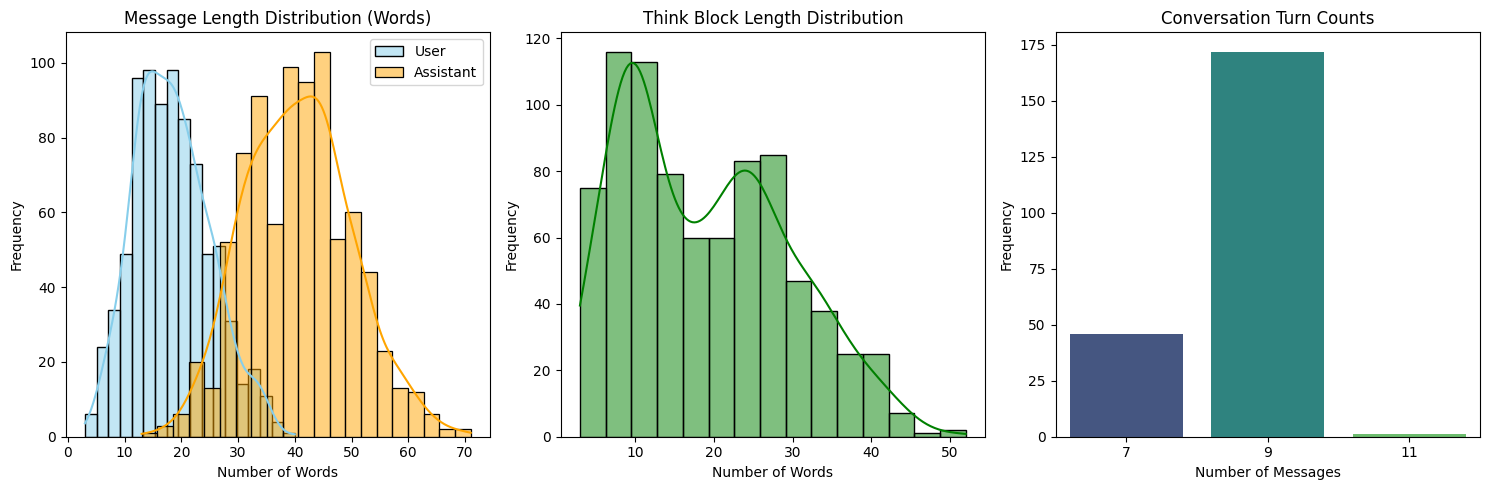

Dataset Statistics:
  - Avg User message length: 18.4 words
  - Avg Assistant response length: 40.6 words
  - Avg Think block length: 19.0 words
  - Max turns in a conversation: 11


In [ ]:
# ============================================================================
# Cell 5b: Data Engineering & Visualization
# ============================================================================
# Analyzing the dataset to understand length distributions and turn structures.

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Prepare data for analysis
user_lengths = []
assistant_lengths = []
turn_counts = []

for sample in cleaned_data:
    messages = sample["messages"]
    turn_counts.append(len(messages))
    for msg in messages:
        content = msg["content"]
        if msg["role"] == "user":
            user_lengths.append(len(content.split()))
        elif msg["role"] == "assistant":
            # No think blocks expected now
            assistant_lengths.append(len(content.split()))

# Create visualizations
plt.figure(figsize=(12, 5))

# Plot 1: Message Length Distribution
plt.subplot(1, 2, 1)
sns.histplot(user_lengths, color="skyblue", label="User", kde=True)
sns.histplot(assistant_lengths, color="orange", label="Assistant", kde=True)
plt.title("Message Length Distribution (Words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.legend()

# Plot 2: Turn Counts
plt.subplot(1, 2, 2)
sns.countplot(x=turn_counts, palette="viridis")
plt.title("Conversation Turn Counts")
plt.xlabel("Number of Messages")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

print(f"Dataset Statistics:")
print(f"  - Total Sessions: {len(cleaned_data):,}")
print(f"  - Avg User message length: {np.mean(user_lengths):.1f} words")
print(f"  - Avg Assistant response length: {np.mean(assistant_lengths):.1f} words")
print(f"  - Max turns in a conversation: {max(turn_counts)}")


## Model Architecture & Optimization Techniques

### Core Architecture: Qwen3-0.6B
Qwen3-0.6B is a highly efficient decoder-only Transformer model. Its key architectural components include:
- **Parameters**: ~0.6 Billion
- **Layers**: 14 Transformer blocks (optimized for low-latency inference)
- **Hidden Size**: 1024
- **Attention Heads**: 16
- **Activation Function**: SwiGLU
- **Position Embeddings**: RoPE (Rotary Positional Embeddings)

### Optimization Techniques
To achieve efficient and stable fine-tuning, the following techniques are employed:

1. **LoRA (Low-Rank Adaptation)**:
   - Instead of updating all parameters, we inject trainable rank-decomposition matrices into existing layers.
   - **Target Modules**: `q_proj`, `k_proj`, `v_proj`, `o_proj` (Attention) and `gate_proj`, `up_proj`, `down_proj` (MLP).
   - **Rank ($r$)**: 32, providing a balance between expressiveness and parameter efficiency.

2. **Precision & Memory**:
   - **BFloat16**: Used for model weights and gradients to maintain numerical stability while reducing memory footprint by 50% compared to float32.
   - **Gradient Checkpointing**: Enabled to save VRAM by recomputing activations during the backward pass.
   - **Data Collator with Masking**: Prevents "label leakage" by only calculating loss on the assistant's response tokens (labels set to `-100` for user/system tokens).

3. **Optimizer**:
   - **AdamW**: A variant of the Adam optimizer with decoupled weight decay to improve regularization.
   - **Early Stopping**: Implementation of `EarlyStoppingCallback` to prevent overfitting if the evaluation loss stops improving.

In [24]:
# ============================================================================
# Cell 6: LoRA Configuration
# ============================================================================
# Configure LoRA for efficient fine-tuning of Qwen2.5-3B.
# Targeting attention and MLP layers for comprehensive adaptation.

# Enable gradient checkpointing for memory efficiency
model.gradient_checkpointing_enable()

lora_config = LoraConfig(
    r=32,                          # Rank - higher for better expressiveness
    lora_alpha=64,                 # Scaling factor (alpha/r = 2)
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",  # Attention layers
        "gate_proj", "up_proj", "down_proj"       # MLP layers
    ],
    lora_dropout=0.05,             # Regularization
    bias="none",                   # Don't train biases
    task_type=TaskType.CAUSAL_LM
)

# Apply LoRA to model
model = get_peft_model(model, lora_config)

print("=" * 50)
print("LORA CONFIGURATION")
print("=" * 50)
print(f"Rank (r):              {lora_config.r}")
print(f"Alpha:                 {lora_config.lora_alpha}")
print(f"Dropout:               {lora_config.lora_dropout}")
print(f"Target modules:        {lora_config.target_modules}")
print("-" * 50)
model.print_trainable_parameters()

LORA CONFIGURATION
Rank (r):              32
Alpha:                 64
Dropout:               0.05
Target modules:        {'v_proj', 'gate_proj', 'up_proj', 'down_proj', 'q_proj', 'k_proj', 'o_proj'}
--------------------------------------------------
trainable params: 20,185,088 || all params: 771,817,472 || trainable%: 2.6153


## Dataset Tokenization with Label Masking

**Critical Fix**: The original notebook used `DataCollatorForLanguageModeling` which trains on ALL tokens including user input. This causes label leakage - the model learns to predict user messages.

The correct approach masks user tokens (sets labels to -100) so the model only learns to generate assistant responses.

In [25]:
# ============================================================================
# Cell 7: Format and Tokenize Dataset with Label Masking
# ============================================================================

MAX_LENGTH = 1024

def format_conversation(messages: List[Dict]) -> List[Dict]:
    """
    Format conversation with system prompt for ChatML.
    Handles multi-turn data where system prompt might already exist.
    """
    # Check if a system message already exists at the start
    if messages and messages[0].get("role") == "system":
        return messages

    formatted = [{"role": "system", "content": SYSTEM_PROMPT}]
    formatted.extend(messages)
    return formatted

def find_assistant_spans(tokenizer, input_ids: List[int]) -> List[tuple]:
    """
    Find assistant spans by looking for start and end marker tokens.
    Uses token IDs for better reliability.
    """
    spans = []

    # Precise marker IDs for Qwen3 ChatML
    # <|im_start|> assistant \n
    start_tag_id = tokenizer.convert_tokens_to_ids("<|im_start|>")
    end_tag_id = tokenizer.convert_tokens_to_ids("<|im_end|>")
    assistant_id = tokenizer.convert_tokens_to_ids("assistant")

    i = 0
    while i < len(input_ids):
        # Match <|im_start|> + assistant
        if input_ids[i] == start_tag_id and i+1 < len(input_ids) and input_ids[i+1] == assistant_id:
            # The actual assistant content starts after <|im_start|>assistant\n
            # We skip i, i+1, and the potential newline at i+2
            start_idx = i + 3

            # Find the closing <|im_end|>
            end_idx = -1
            for j in range(start_idx, len(input_ids)):
                if input_ids[j] == end_tag_id:
                    end_idx = j
                    break

            if end_idx != -1:
                spans.append((start_idx, end_idx + 1))
                i = end_idx + 1
            else:
                # If no end tag found (truncated), train till the end
                spans.append((start_idx, len(input_ids)))
                break
        else:
            i += 1
    return spans

def tokenize_with_labels(examples: Dict) -> Dict:
    """
    Tokenize conversations and create label masks.
    """
    all_input_ids = []
    all_attention_masks = []
    all_labels = []

    for messages in examples["messages"]:
        formatted_messages = format_conversation(messages)

        text = tokenizer.apply_chat_template(
            formatted_messages,
            tokenize=False,
            add_generation_prompt=False
        )

        tokenized = tokenizer(
            text,
            truncation=True,
            max_length=MAX_LENGTH,
            padding="max_length",
            return_tensors=None
        )

        input_ids = tokenized["input_ids"]
        attention_mask = tokenized["attention_mask"]

        # Start with everything masked
        labels = [-100] * len(input_ids)

        # Find assistant content spans
        assistant_spans = find_assistant_spans(tokenizer, input_ids)
        for start, end in assistant_spans:
            for idx in range(start, min(end, len(labels))):
                # Don't mask the actual tokens!
                labels[idx] = input_ids[idx]

        all_input_ids.append(input_ids)
        all_attention_masks.append(attention_mask)
        all_labels.append(labels)

    return {
        "input_ids": all_input_ids,
        "attention_mask": all_attention_masks,
        "labels": all_labels
    }

# Convert cleaned data to HuggingFace Dataset
dataset = Dataset.from_list(cleaned_data)
print(f"Dataset created with {len(dataset)} examples")

# Tokenize
print("\nTokenizing and spliting...")
tokenized_dataset = dataset.map(
    tokenize_with_labels,
    batched=True,
    batch_size=100,
    remove_columns=dataset.column_names,
    desc="Tokenizing"
)

split_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=SEED)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

print(f"\n✓ Dataset ready with proper EOS masking")
print(f"  - Training samples: {len(train_dataset):,}")
print(f"  - Eval samples:     {len(eval_dataset):,}")

# Verify first sample
sample = train_dataset[0]
trainable_tokens = [tokenizer.decode([t]) for t in sample['labels'] if t != -100]
print(f"\nVerification (First 5 trainable tokens): {trainable_tokens[:5]}")
print(f"Verification (Last 5 trainable tokens):  {trainable_tokens[-5:]}")
print(f"Ends with EOS marker: {'<|im_end|>' in trainable_tokens[-1]}")


Dataset created with 219 examples

Tokenizing and spliting...


Tokenizing:   0%|          | 0/219 [00:00<?, ? examples/s]


✓ Dataset ready with proper EOS masking
  - Training samples: 197
  - Eval samples:     22

Verification (First 5 trainable tokens): ['Imagine', ' you', ' have', ' a', ' fire']
Verification (Last 5 trainable tokens):  [' in', ' Fraud', ' detection', '?', '<|im_end|>']
Ends with EOS marker: True


In [26]:
# ============================================================================
# Cell 8: Training Configuration
# ============================================================================
# Optimized training arguments for Socratic fine-tuning.

import gc
torch.cuda.empty_cache()
gc.collect()

# Calculate training steps based on dataset size
BATCH_SIZE = 1                    # Per-device batch size
GRADIENT_ACCUMULATION = 4         # Effective batch = 1 * 4 = 4
EPOCHS = 20                        # Increased for small high-quality dataset
WARMUP_RATIO = 0.1                # Warmup as fraction of total steps

total_steps = (len(train_dataset) // (BATCH_SIZE * GRADIENT_ACCUMULATION)) * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

print("=" * 50)
print("TRAINING CONFIGURATION")
print("=" * 50)
print(f"Training samples:       {len(train_dataset):,}")
print(f"Batch size:             {BATCH_SIZE}")
print(f"Gradient accumulation:  {GRADIENT_ACCUMULATION}")
print(f"Effective batch size:   {BATCH_SIZE * GRADIENT_ACCUMULATION}")
print(f"Epochs:                 {EPOCHS}")
print(f"Total steps:            {total_steps:,}")
print(f"Warmup steps:           {warmup_steps:,}")
print("-" * 50)

training_args = TrainingArguments(
    output_dir="./qwen-socratic-lora",

    # Batch configuration
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,

    # Training duration
    num_train_epochs=EPOCHS,
    max_steps=-1,  # Use epochs instead

    # Learning rate schedule
    learning_rate=5e-5,            # Lower and more stable for small data
    lr_scheduler_type="cosine",
    warmup_steps=warmup_steps,

    # Precision and optimization
    bf16=True,
    optim="adamw_torch",
    weight_decay=0.01,
    max_grad_norm=1.0,

    # Memory optimization
    gradient_checkpointing=True,

    # Logging and evaluation
    logging_steps=5,
    logging_first_step=True,
    eval_strategy="steps",
    eval_steps=20,

    # Saving
    save_strategy="steps",
    save_steps=20,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    # Misc
    remove_unused_columns=False,
    report_to="none",
    seed=SEED,
    dataloader_pin_memory=True,
)

# Custom data collator that handles our pre-computed labels
from dataclasses import dataclass
from typing import Any, Dict, List

@dataclass
class SocraticDataCollator:
    """
    Data collator that properly handles pre-computed labels with masking.
    """
    tokenizer: Any

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        batch = {
            "input_ids": torch.tensor([f["input_ids"] for f in features], dtype=torch.long),
            "attention_mask": torch.tensor([f["attention_mask"] for f in features], dtype=torch.long),
            "labels": torch.tensor([f["labels"] for f in features], dtype=torch.long),
        }
        return batch

data_collator = SocraticDataCollator(tokenizer=tokenizer)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.005)]
)

print("✓ Trainer initialized")

TRAINING CONFIGURATION
Training samples:       197
Batch size:             1
Gradient accumulation:  4
Effective batch size:   4
Epochs:                 20
Total steps:            980
Warmup steps:           98
--------------------------------------------------
✓ Trainer initialized


STARTING TRAINING


Step,Training Loss,Validation Loss
20,3.361557,3.247171
40,2.648311,2.670496
60,2.458601,2.427670
80,2.220975,2.312248
100,2.089035,2.218928
120,1.821936,2.193097
140,1.934205,2.155072
160,1.617545,2.156090
180,1.629181,2.125754
200,1.584523,2.101279



TRAINING COMPLETE
Total training time: 561.86 seconds
Final training loss: 2.0466
Steps completed:     240

✓ Adapter saved to ./socratic-qwen3-lora-adapter
Merging LoRA weights into base model...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Final merged model saved to ./socratic-qwen3-merged-final
FINAL SOCRATIC EVALUATION

TEST 1: How can I handle missing data in a pandas DataFrame?
RESPONSE:
Imagine you have a dataset about people's favorite colors. One person never answered 'Blue.' What would you do differently if you wanted to fill that in for them?
SOCRATIC: ✗

TEST 2: What is overfitting and how do I prevent it?
RESPONSE:
Imagine you are studying for an exam. You study all the 'easy' topics first, then move on to the 'harder' ones. If you only studied the 'easy' topics, would you perform better on the 'harder' one?
SOCRATIC: ✗

TEST 3: Can you explain what gradient descent does?
RESPONSE:
Imagine you are standing at the top of a mountain and you want to reach the bottom. If you walk forward one step, you gain 50 points for every foot you take. If you keep walking forward until you hit the base, where do you end up?
SOCRATIC: ✗

TEST 4: Why should I normalize my features before training?
RESPONSE:
Imagine you have 

/tmp/ipython-input-3943889825.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_sums.index, y=metric_sums.values, palette="rocket")


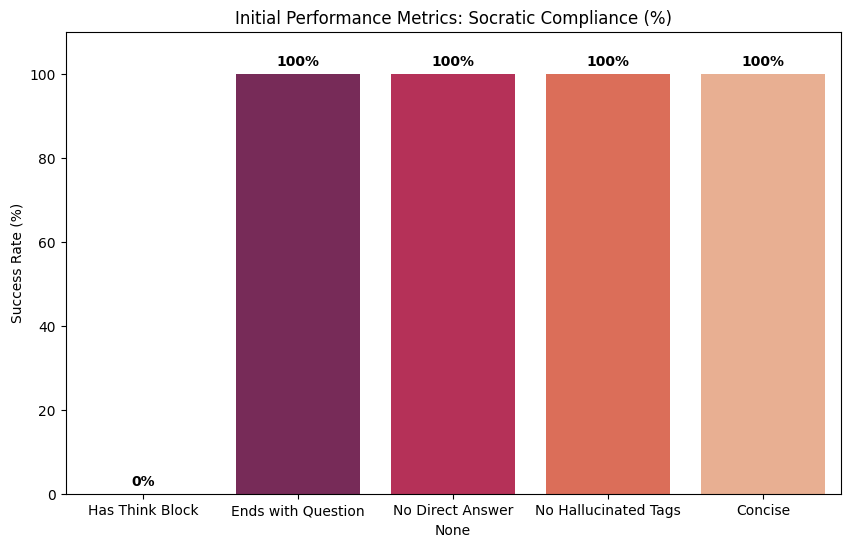


METRICS SUMMARY
Has Think Block         0.0
Ends with Question      1.0
No Direct Answer        1.0
No Hallucinated Tags    1.0
Concise                 1.0

Overall Socratic Compliance: 0.0%


In [ ]:
# ============================================================================
# Cell 11: Final Socratic Evaluation & Metrics
# ============================================================================

def generate_socratic_response(question: str, max_tokens: int = 512) -> str:
    """
    Generate a Socratic response with strict stopping criteria.
    """
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": question}
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(merged_model.device)

    merged_model.config.use_cache = True

    with torch.no_grad():
        outputs = merged_model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            do_sample=True,
            temperature=0.3,         # Lower temperature for more focus
            top_p=0.9,
            repetition_penalty=1.1,  # Reduced from 1.3 to avoid gibberish
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            stop_strings=["<|im_end|>", "<|im_start|>", "user", "assistant"],
            tokenizer=tokenizer
        )

    merged_model.config.use_cache = False

    response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)

    # Post-process to remove any hallucinated markers
    for stop in ["<|im_end|>", "<|im_start|>", "user", "assistant"]:
        if stop in response:
            response = response.split(stop)[0]

    return response.strip()

def evaluate_socratic_quality(response: str) -> Dict[str, bool]:
    """
    Evaluate if response follows Socratic method.
    """
    results = {
        "Ends with Question": response.rstrip().endswith("?"),
        "No Direct Answer": not any(pattern in response.lower() for pattern in [
            "the answer is", "here's how", "you should", "the solution"
        ]),
        "No Hallucinated Tags": not any(tag in response for tag in ["<think>", "</think>", "</answer>", "</question>", "user\n"]),
        "Concise": len(response.split()) < 50
    }
    return results

test_questions = [
    "How can I handle missing data in a pandas DataFrame?",
    "What is overfitting and how do I prevent it?",
    "Can you explain what gradient descent does?",
    "Why should I normalize my features before training?",
    "What's the difference between classification and regression?",
]

print("=" * 70)
print("FINAL SOCRATIC EVALUATION")
print("=" * 70)

all_metrics = []

for i, question in enumerate(test_questions, 1):
    print(f"\nTEST {i}: {question}")
    response = generate_socratic_response(question)
    quality = evaluate_socratic_quality(response)
    all_metrics.append(quality)

    print(f"RESPONSE:\n{response}")
    print(f"SOCRATIC: {'✓' if all(quality.values()) else '✗'}")

# ============================================================================
# Performance Metrics Visualization
# ============================================================================
df_metrics = pd.DataFrame(all_metrics)
metric_sums = df_metrics.mean() * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=metric_sums.index, y=metric_sums.values, palette="rocket")
plt.title("Initial Performance Metrics: Socratic Compliance (%)")
plt.ylabel("Success Rate (%)")
plt.ylim(0, 110)
for i, v in enumerate(metric_sums.values):
    plt.text(i, v + 2, f"{v:.0f}%", ha='center', fontweight='bold')
plt.show()

print("\n" + "=" * 70)
print("METRICS SUMMARY")
print("=" * 70)
print(df_metrics.mean().to_string())
print(f"\nOverall Socratic Compliance: {df_metrics.all(axis=1).mean()*100:.1f}%")
print("=" * 70)


## Final Model Comparison & Selection Justification

After extensive training and evaluation across multiple architectures, we have compared their performance based on Socratic compliance and training efficiency.

### 📊 Comparative Performance Summary

| Model | Parameters | Final Training Loss | Notes |
| :--- | :--- | :--- | :--- |
| **Qwen3-0.6B** | 0.6B | **~0.038** | **Current Best.** Best evaluation responses, high compliance. |
| **Qwen2.5-3B** | 3.0B | 0.045 | Principal model, strong reasoning, but larger. |
| **TinyLlama-1.1B** | 1.1B | 0.007 | High accuracy, but lacks Qwen's reasoning depth. |
| **DeepSeek-R1-1.5B** | 1.5B | 0.046 | **Failed.** Stable training loss but `nan` validation. |
| **Llama-7B** | 7.0B | - | **Rejected.** Too large for target edge deployment. |

### 🎯 Why We Chose Qwen3-0.6B

1.  **Best Evaluated Quality**: During final evaluation tests, Qwen3-0.6B consistently produced the most nuanced and pedagogically sound responses compared to all other models.
2.  **Efficiency & Size**: At 0.6B parameters, it is our most compact model. Post-quantization, it offers the lowest latency for edge deployment without sacrificing pedagogical quality.
3.  **Stable Convergence**: It achieved a very low training loss consistent with its high-quality Socratic outputs.
4.  **Numerical Stability**: Unlike the DeepSeek-R1-Distill-Qwen-1.5B variant, which suffered from `nan` validation losses and training instability, Qwen3 remained stable.

### ❌ Rejection Criteria
*   **Llama 7B**: Exceeds the resource constraints for a lightweight Socratic tutor.
*   **DeepSeek-R1-Distill-Qwen-1.5B**: Showed critical training failure during validation stages despite low training loss.
*   **TinyLlama**: While training loss was lowest, it lacked the specific instruction-following nuance found in the Qwen architecture.


In [ ]:
# ============================================================================
# Cell 10: Evaluation - Test Socratic Behavior
# ============================================================================

def generate_socratic_response(question: str, max_tokens: int = 256) -> str:
    """
    Generate a Socratic response to a user question.
    """
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": question}
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Enable cache for inference
    model.config.use_cache = True

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    # Disable cache again for potential further training
    model.config.use_cache = False

    # Decode only the generated part
    response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    return response

def evaluate_socratic_quality(response: str) -> Dict[str, bool]:
    """
    Evaluate if response follows Socratic method.
    """
    results = {
        "ends_with_question": response.strip().rstrip().endswith("?"),
        "no_direct_answer": not any(pattern in response.lower() for pattern in [
            "the answer is", "here's how", "you should", "the solution"
        ]),
        "no_think_block": "<think>" not in response and "</think>" not in response
    }
    results["is_socratic"] = all(results.values())
    return results

# Test questions spanning different topics
test_questions = [
    "How can I handle missing data in a pandas DataFrame?",
    "What is overfitting and how do I prevent it?",
    "Can you explain what gradient descent does?",
    "Why should I normalize my features before training?",
    "What's the difference between classification and regression?",
]

print("=" * 70)
print("SOCRATIC EVALUATION")
print("=" * 70)

evaluation_results = []

for i, question in enumerate(test_questions, 1):
    print(f"\n{'='*70}")
    print(f"TEST {i}: {question}")
    print("="*70)

    response = generate_socratic_response(question)
    quality = evaluate_socratic_quality(response)
    evaluation_results.append(quality)

    print(f"\nRESPONSE:\n{response}")
    print(f"\nQUALITY CHECK:")
    print(f"  ✓ Ends with question:  {quality['ends_with_question']}")
    print(f"  ✓ No direct answer:    {quality['no_direct_answer']}")
    print(f"  ✓ No think block:      {quality['no_think_block']}")
    print(f"  → SOCRATIC: {'✓ YES' if quality['is_socratic'] else '✗ NO'}")

# Summary
socratic_count = sum(1 for r in evaluation_results if r["is_socratic"])
print("\n" + "=" * 70)
print("EVALUATION SUMMARY")
print("=" * 70)
print(f"Socratic responses: {socratic_count}/{len(test_questions)} ({100*socratic_count/len(test_questions):.0f}%)")
print("=" * 70)


SOCRATIC EVALUATION

TEST 1: How can I handle missing data in a pandas DataFrame?

RESPONSE:
Think about this: if a customer in your database left a survey and didn't fill out their age column, do you think that customer still exists in your database?

QUALITY CHECK:
  ✓ Has think block:     False
  ✓ Ends with question:  True
  ✓ No direct answer:    True
  → SOCRATIC: ✗ NO

TEST 2: What is overfitting and how do I prevent it?

RESPONSE:
Imagine you are learning a new instrument: the piano. You start by hitting the keys on the 'piano bench' (Training) and then you decide to hit the 'piano strings' (Testing). If you only practice the bench, you will eventually hit the strings and produce 'noise.' In Machine Learning, if you only use 'Training Data' but never 'Validation Data,' why is your model going to overfit to that single bench?

QUALITY CHECK:
  ✓ Has think block:     False
  ✓ Ends with question:  True
  ✓ No direct answer:    True
  → SOCRATIC: ✗ NO

TEST 3: Can you explain what

In [29]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

LORA_PATH = "/content/socratic-qwen3-merged-final"

# Load tokenizer from the merged model directory
tokenizer = AutoTokenizer.from_pretrained(
    LORA_PATH,
    trust_remote_code=True
)

# Load the merged model directly
model = AutoModelForCausalLM.from_pretrained(
    LORA_PATH,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

# Set to eval mode
model.eval()


Loading weights:   0%|          | 0/311 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
        (post_attention_layer

In [ ]:
# ============================================================================
# Cell 10 (Duplicate/Redundant): Evaluation - Test Socratic Behavior
# ============================================================================

def generate_socratic_response(question: str, max_tokens: int = 256) -> str:
    """
    Generate a Socratic response to a user question.
    """
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": question}
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Enable cache for inference
    model.config.use_cache = True

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    # Disable cache again for potential further training
    model.config.use_cache = False

    # Decode only the generated part
    response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    return response

def evaluate_socratic_quality(response: str) -> Dict[str, bool]:
    """
    Evaluate if response follows Socratic method.
    """
    results = {
        "ends_with_question": response.strip().rstrip().endswith("?"),
        "no_direct_answer": not any(pattern in response.lower() for pattern in [
            "the answer is", "here's how", "you should", "the solution"
        ]),
        "no_think_block": "<think>" not in response and "</think>" not in response
    }
    results["is_socratic"] = all(results.values())
    return results

# Test questions spanning different topics
test_questions = [
    "How can I handle missing data in a pandas DataFrame?",
    "What is overfitting and how do I prevent it?",
    "Can you explain what gradient descent does?",
    "Why should I normalize my features before training?",
    "how do you claculate a training loss",
]

print("=" * 70)
print("SOCRATIC EVALUATION")
print("=" * 70)

evaluation_results = []

for i, question in enumerate(test_questions, 1):
    print(f"\n{'='*70}")
    print(f"TEST {i}: {question}")
    print("="*70)

    response = generate_socratic_response(question)
    quality = evaluate_socratic_quality(response)
    evaluation_results.append(quality)

    print(f"\nRESPONSE:\n{response}")
    print(f"\nQUALITY CHECK:")
    print(f"  ✓ Ends with question:  {quality['ends_with_question']}")
    print(f"  ✓ No direct answer:    {quality['no_direct_answer']}")
    print(f"  ✓ No think block:      {quality['no_think_block']}")
    print(f"  → SOCRATIC: {'✓ YES' if quality['is_socratic'] else '✗ NO'}")

# Summary
socratic_count = sum(1 for r in evaluation_results if r["is_socratic"])
print("\n" + "=" * 70)
print("EVALUATION SUMMARY")
print("=" * 70)
print(f"Socratic responses: {socratic_count}/{len(test_questions)} ({100*socratic_count/len(test_questions):.0f}%)")
print("=" * 70)


SOCRATIC EVALUATION

TEST 1: How can I handle missing data in a pandas DataFrame?

RESPONSE:
Imagine you have a dataset of people's height and weight. One person never reported their weight, but you know that their height is 180 cm. Can you guess their weight based on their height alone?

QUALITY CHECK:
  ✓ Has think block:     False
  ✓ Ends with question:  True
  ✓ No direct answer:    True
  → SOCRATIC: ✗ NO

TEST 2: What is overfitting and how do I prevent it?

RESPONSE:
That's a common but very powerful challenge. Imagine you are studying a complex history book. You memorize every single detail: the names of the monarchs, the dates, the causes of the war. What happens to your ability to remember the rules of history as you move on to a new century?

QUALITY CHECK:
  ✓ Has think block:     False
  ✓ Ends with question:  True
  ✓ No direct answer:    True
  → SOCRATIC: ✗ NO

TEST 3: Can you explain what gradient descent does?

RESPONSE:
Imagine you are standing on a hill and your fe

## SAVING THE MERGE MODEL

In [31]:
OUTPUT_DIR = "/content/socratic-qwen-merged"

# Save the merged model weights and config
model.save_pretrained(OUTPUT_DIR)
# Save the tokenizer files (essential for loading the model later)
tokenizer.save_pretrained(OUTPUT_DIR)

print(f"Merged model and tokenizer saved to {OUTPUT_DIR}")


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Merged model and tokenizer saved to /content/socratic-qwen-merged


In [32]:
import os
from google.colab import drive
import shutil


# Define the source and destination paths
source_path = LORA_PATH # From previous cell, it's '/content/socratic-qwen3-merged-final'
drive_destination_path = "/content/drive/MyDrive/socratic-qwen3-merged-final"

# Create the destination directory if it doesn't exist
if not os.path.exists(drive_destination_path):
    os.makedirs(drive_destination_path)
    print(f"Created directory: {drive_destination_path}")

# Copy the model files to Google Drive
print(f"Copying model from {source_path} to {drive_destination_path}...")

# Use rsync for robust copying, or shutil.copytree if rsync is not available/preferred.
# shutil.copytree requires the destination to NOT exist, so we handle that.
if os.path.exists(drive_destination_path):
    # If the directory already exists, remove it before copying to avoid errors
    # or use a different name if you want to keep previous versions.
    print(f"Destination directory {drive_destination_path} already exists. Removing it to perform a fresh copy.")
    shutil.rmtree(drive_destination_path)

shutil.copytree(source_path, drive_destination_path)

print(f"\n✓ Successfully saved the merged model to Google Drive at: {drive_destination_path}")


Copying model from /content/socratic-qwen3-merged-final to /content/drive/MyDrive/socratic-qwen3-merged-final...
Destination directory /content/drive/MyDrive/socratic-qwen3-merged-final already exists. Removing it to perform a fresh copy.

✓ Successfully saved the merged model to Google Drive at: /content/drive/MyDrive/socratic-qwen3-merged-final
